In [1]:
import TechCore.Simulator.simulator_optimized as simulator

from TechCore.Strategies import Future, Midprice, Stoikov

import TechCore.Simulator.get_info as get_info
import TechCore.Simulator.load_data as load_data

from importlib import reload

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

path_to_file = '../TechCore/data/md/btcusdt_Binance_LinearPerpetual/'

In [2]:
run_time = pd.Timedelta(10, 'm').delta
md = load_data.load_md_from_file(path=path_to_file, run_time=run_time)

In [3]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta
delay = pd.Timedelta(0.1, 's').delta

In [4]:
reload(simulator)

reload(Future)
reload(Midprice)
reload(Stoikov)

reload(get_info)
reload(load_data)

<module 'TechCore.Simulator.load_data' from 'C:\\Users\\artem\\.Computer Science\\CMF\\Projects\\High_Frequency_Market_Making\\TechCore\\Simulator\\load_data.py'>

In [5]:
def run_stoikov(gamma):
    reload(simulator)
    reload(Stoikov)
    reload(get_info)
    reload(load_data)

    sim = simulator.SimOptim(md, latency, md_latency)

    strat = Stoikov.Strategy(
        delay=delay,
        risk_koef=gamma,
        time_oi=60*10**9,
        avg_sum_oi=800,
        avg_time_oi=57471412238,
        order_fees=-0.00001,
        avg_volatility=25,
        min_asset_value=0.001,
        volatility_record_cooldown=0.1*10**9, #ns
        volatility_horizon=1000,
        order_intensity_min_samples=100
    )
    strat.run(sim)
    return strat.logs

In [6]:
def run_future(gamma):
    reload(simulator)
    reload(Future)
    reload(get_info)
    reload(load_data)

    sim = simulator.SimOptim(md, latency, md_latency)

    strat = Future.Strategy(
        delay=delay,
        future_timestamp=10**9, #ns
        risk_koef=gamma,
        time_oi=60*10**9,
        avg_sum_oi=800,
        avg_time_oi=57471412238,
        order_fees=-0.00001,
        avg_volatility=25,
        min_asset_value=0.001,
        volatility_record_cooldown=0.1*10**9, #ns
        volatility_horizon=1000,
        order_intensity_min_samples=100
    )
    strat.run(sim)
    return strat.logs

In [7]:
def run_midprice(gamma):
    reload(simulator)
    reload(Midprice)
    reload(get_info)
    reload(load_data)

    sim = simulator.SimOptim(md, latency, md_latency)

    strat = Midprice.Strategy(
        delay=delay,
        risk_koef=gamma,
        time_oi=60*10**9,
        avg_sum_oi=800,
        avg_time_oi=57471412238,
        order_fees=0.00001,
        avg_volatility=25,
        min_asset_value=-0.001,
        volatility_record_cooldown=0.1*10**9, #ns
        volatility_horizon=1000,
        order_intensity_min_samples=100
    )
    strat.run(sim)
    return strat.logs

In [8]:
future_logs = run_future(1)
midprice_logs = run_midprice(1)
stoikov_logs = run_stoikov(1)

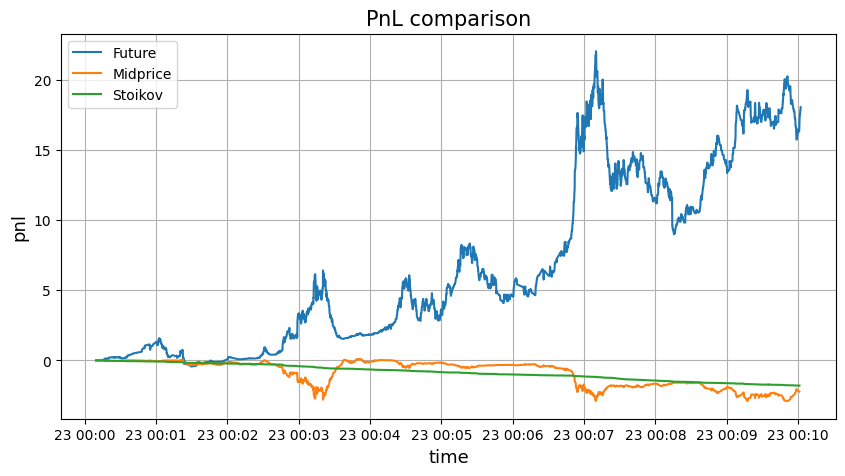

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(future_logs['own_trade_time']), future_logs['pnl'], label='Future')
plt.plot(pd.to_datetime(midprice_logs['own_trade_time']), midprice_logs['pnl'], label='Midprice')
plt.plot(pd.to_datetime(stoikov_logs['own_trade_time']), stoikov_logs['pnl'], label='Stoikov')
plt.xlabel('time', fontsize=13)
plt.ylabel('pnl', fontsize=13)
plt.title('PnL comparison', fontsize=15)
plt.legend()
plt.grid()
plt.show()

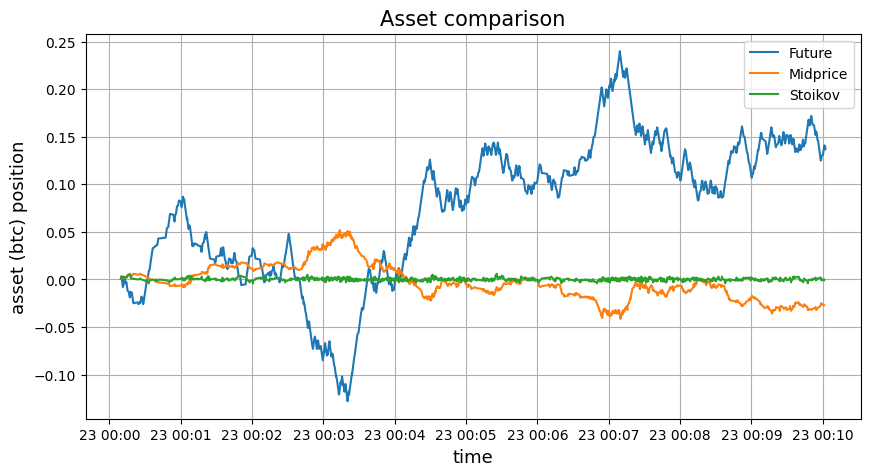

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(future_logs['own_trade_time']), future_logs['asset_position'], label='Future')
plt.plot(pd.to_datetime(midprice_logs['own_trade_time']), midprice_logs['asset_position'], label='Midprice')
plt.plot(pd.to_datetime(stoikov_logs['own_trade_time']), stoikov_logs['asset_position'], label='Stoikov')
plt.xlabel('time', fontsize=13)
plt.ylabel('asset (btc) position', fontsize=13)
plt.title('Asset comparison', fontsize=15)
plt.legend()
plt.grid()
plt.show()

Видим тут, что Стоиков очень стабилен. В плане - при оценке чего угодно существует такая штука как Sharp Ratio. Лучше стабильно возрастать, чем скакать вокруг нуля и оказаться, что к концу периода мы в плюсе.

Если у нас получится получить "Стоикова" с прибылью (например начать юзать предсказание future price), будет очень хорошо.

Кстати Maximum Drawdown у Стоикова тоже лучше всех (просто руками видно).

# Теперь сравним в зависимости от гамма

In [11]:
gamma_list = [10**i for i in range(-6, 2)]
gamma_list

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [12]:
future_gamma_logs = []
midprice_gamma_logs = []
stoikov_gamma_logs = []

for gamma in gamma_list:
    future_gamma_logs.append(run_future(gamma))
    midprice_gamma_logs.append(run_midprice(gamma))
    stoikov_gamma_logs.append(run_stoikov(gamma))

## Future

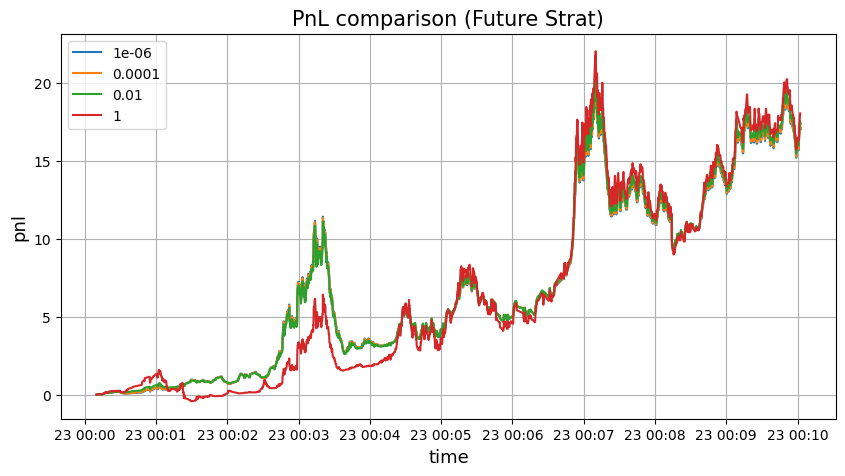

In [13]:
plt.figure(figsize=(10, 5))
for gamma, log in zip(gamma_list[::2], future_gamma_logs[::2]):
    plt.plot(pd.to_datetime(log['own_trade_time']), log['pnl'], label=gamma)
plt.xlabel('time', fontsize=13)
plt.ylabel('pnl', fontsize=13)
plt.title('PnL comparison (Future Strat)', fontsize=15)
plt.legend()
plt.grid()
plt.show()

Имхо из этой разницы сложно что-то получить.

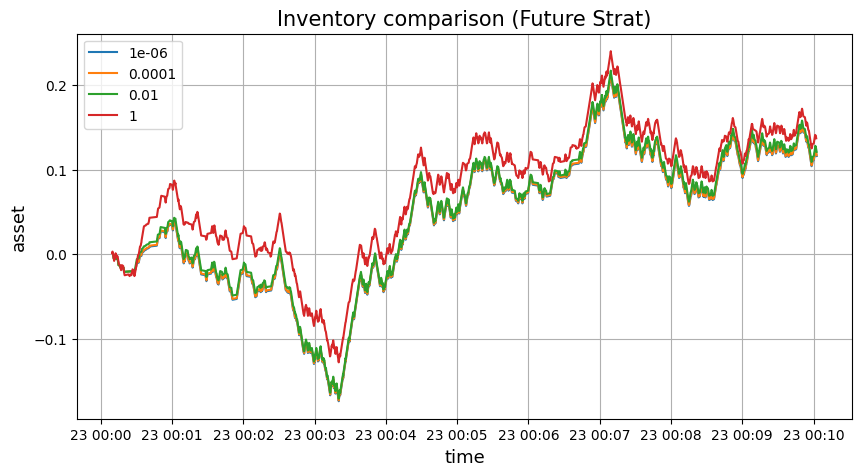

In [14]:
plt.figure(figsize=(10, 5))
for gamma, log in zip(gamma_list[::2], future_gamma_logs[::2]):
    plt.plot(pd.to_datetime(log['own_trade_time']), log['asset_position'], label=gamma)
plt.xlabel('time', fontsize=13)
plt.ylabel('asset', fontsize=13)
plt.title('Inventory comparison (Future Strat)', fontsize=15)
plt.legend()
plt.grid()
plt.show()

Туда же

## Midprice

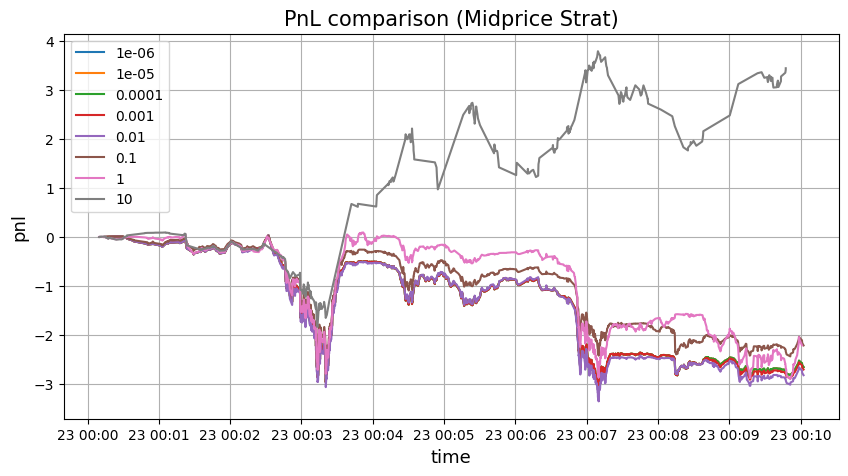

In [15]:
plt.figure(figsize=(10, 5))
for gamma, log in zip(gamma_list[::1], midprice_gamma_logs[::1]):
    plt.plot(pd.to_datetime(log['own_trade_time']), log['pnl'], label=gamma)
plt.xlabel('time', fontsize=13)
plt.ylabel('pnl', fontsize=13)
plt.title('PnL comparison (Midprice Strat)', fontsize=15)
plt.legend()
plt.grid()
plt.show()

Все таки 10 в midprice лишком большой outlier

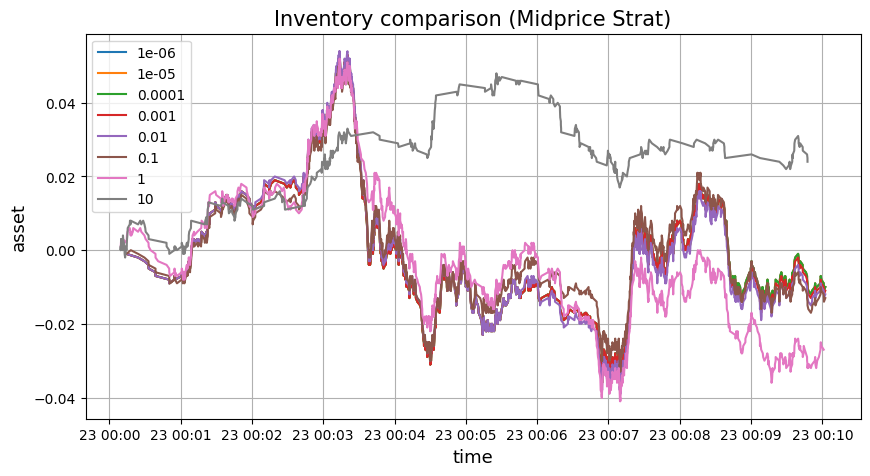

In [19]:
plt.figure(figsize=(10, 5))
for gamma, log in zip(gamma_list[::1], midprice_gamma_logs[::1]):
    plt.plot(pd.to_datetime(log['own_trade_time']), log['asset_position'], label=gamma)
plt.xlabel('time', fontsize=13)
plt.ylabel('asset', fontsize=13)
plt.title('Inventory comparison (Midprice Strat)', fontsize=15)
plt.legend()
plt.grid()
plt.show()

## Stoikov

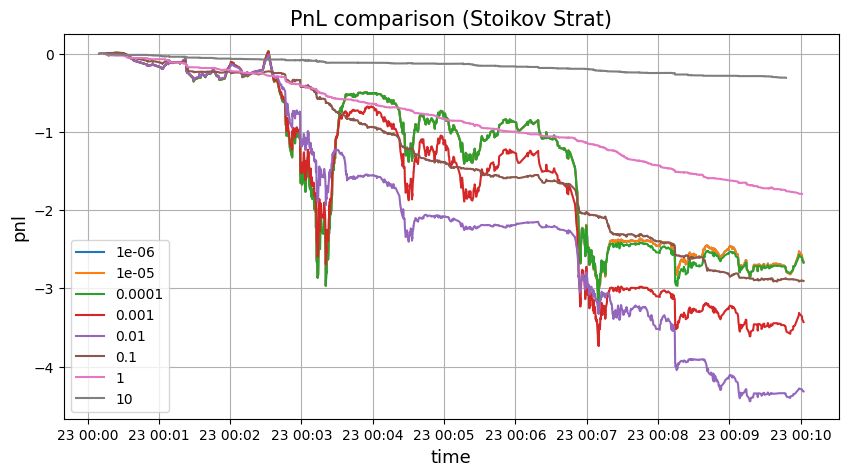

In [17]:
plt.figure(figsize=(10, 5))
for gamma, log in zip(gamma_list[::1], stoikov_gamma_logs[::1]):
    plt.plot(pd.to_datetime(log['own_trade_time']), log['pnl'], label=gamma)
plt.xlabel('time', fontsize=13)
plt.ylabel('pnl', fontsize=13)
plt.title('PnL comparison (Stoikov Strat)', fontsize=15)
plt.legend()
plt.grid()
plt.show()

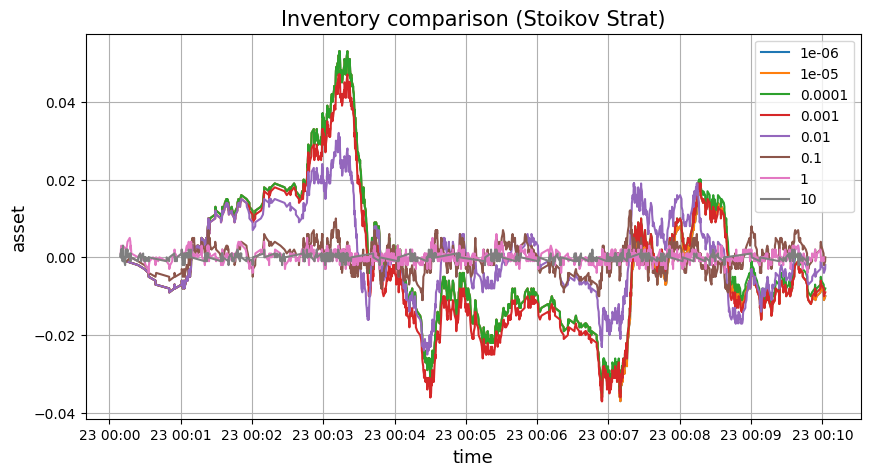

In [18]:
plt.figure(figsize=(10, 5))
for gamma, log in zip(gamma_list[::1], stoikov_gamma_logs[::1]):
    plt.plot(pd.to_datetime(log['own_trade_time']), log['asset_position'], label=gamma)
plt.xlabel('time', fontsize=13)
plt.ylabel('asset', fontsize=13)
plt.title('Inventory comparison (Stoikov Strat)', fontsize=15)
plt.legend()
plt.grid()
plt.show()

Мы видим, как при уменьшении gamma Stoikov -> Midprice.
gamma = 10 и мы просто перестаем торговать